# RNN

![RNN](rnn.png)

### CONFIG

In [1]:
CFG = {
    "batch_size": 64,
    "input_seq": 48,
    "output_seq": 6,
    "num_workers": 0,
    "lr": 0.001,
    "epochs": 50,
    "dropout": 0
}

CFG

{'batch_size': 64,
 'input_seq': 48,
 'output_seq': 6,
 'num_workers': 0,
 'lr': 0.001,
 'epochs': 50,
 'dropout': 0}

### MODULES

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler

### LOAD DATA

In [3]:
data = pd.read_csv("air_quality_italian_city.csv", delimiter=";", decimal=',', usecols=["Date", "Time", "T"])
data.index = pd.to_datetime(data["Date"]+" "+data["Time"], format="%d/%m/%Y %H.%M.%S")
data = data.drop(["Date", "Time"], axis=1)
data

,T
2004-03-10 18:00:00,13.6
2004-03-10 19:00:00,13.3
2004-03-10 20:00:00,11.9
2004-03-10 21:00:00,11.0
2004-03-10 22:00:00,11.2
...,...
2005-04-04 10:00:00,21.9
2005-04-04 11:00:00,24.3
2005-04-04 12:00:00,26.9
2005-04-04 13:00:00,28.3


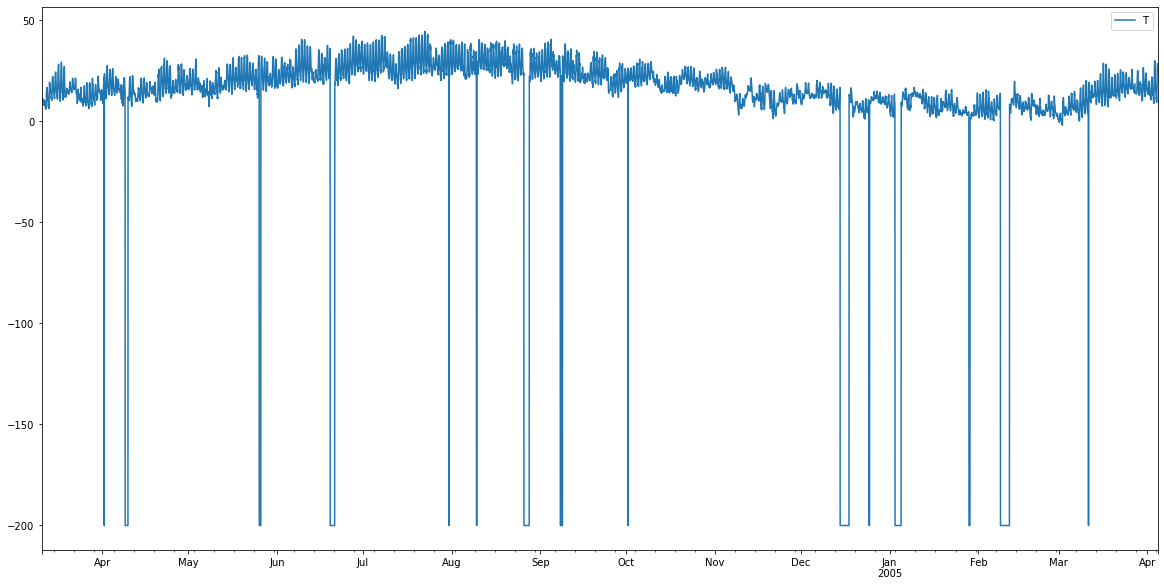

In [4]:
data.plot(figsize=(20, 10))

### CLEAN DATA

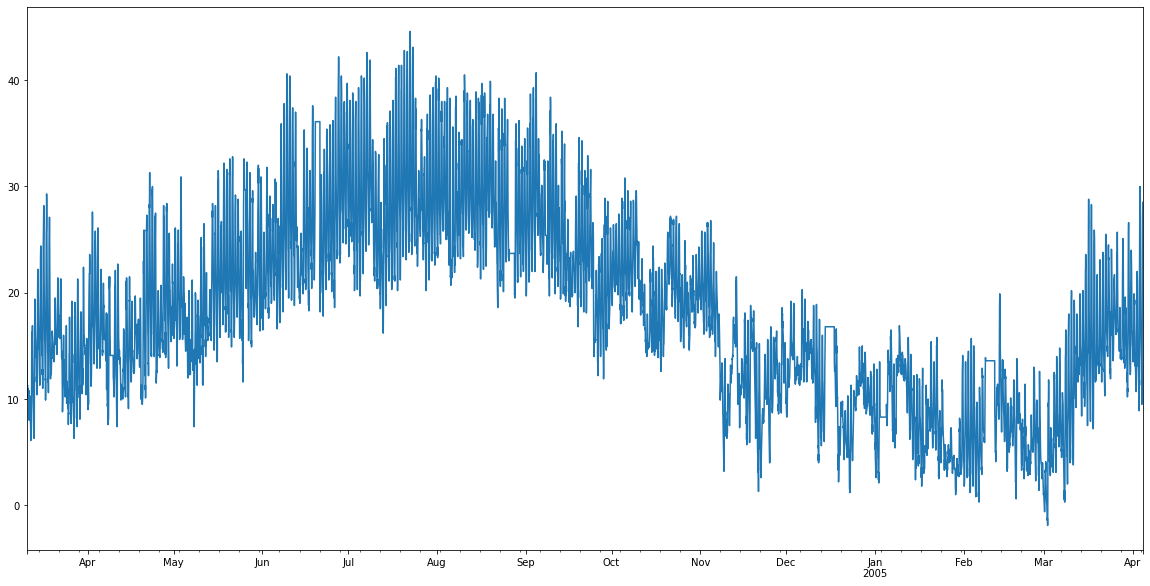

In [5]:
data.loc[data["T"] == data["T"].min(), "T"] = np.NaN
data = data["T"].fillna(method="ffill")
data.plot(figsize=(20, 10))

### GENERATE SEQUENCES

In [6]:
def gen_seqs(data, input_seq, output_seq):
    data = np.array(data)
    xs = []
    ys = []
    for i in range(len(data)-input_seq-output_seq+1):
        x = data[i:i+input_seq]
        y = data[i+input_seq:i+input_seq+output_seq]
        xs.append(x)
        ys.append(y)

    return np.stack(xs).reshape(-1, input_seq, 1), np.stack(ys).reshape(-1, output_seq, 1)

    
x, y = gen_seqs(data, CFG["input_seq"], CFG["output_seq"])
x.shape, y.shape

((9304, 48, 1), (9304, 6, 1))

### DATA SPLIT

In [7]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42, shuffle=False)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=42, shuffle=False)
x_train.shape, x_val.shape, x_test.shape, y_train.shape, y_val.shape, y_test.shape

((5582, 48, 1),
 (1861, 48, 1),
 (1861, 48, 1),
 (5582, 6, 1),
 (1861, 6, 1),
 (1861, 6, 1))

### DATASET

In [8]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        sample, label = self.x[idx], self.y[idx]
        sample, label = torch.tensor(sample), torch.tensor(label)
        return sample, label
    
    
data = {
    "train": Dataset(x_train, y_train),
    "val": Dataset(x_val, y_val),
    "test": Dataset(x_test, y_test)
}

data_loader = {
    "train": torch.utils.data.DataLoader(data["train"], batch_size=CFG["batch_size"], num_workers=CFG["num_workers"], pin_memory=False, shuffle=False),
    "val": torch.utils.data.DataLoader(data["val"], batch_size=CFG["batch_size"], num_workers=CFG["num_workers"], pin_memory=False, shuffle=False),
    "test": torch.utils.data.DataLoader(data["test"], batch_size=CFG["batch_size"], num_workers=CFG["num_workers"], pin_memory=False, shuffle=False)
}

len(data["train"]), len(data["val"]), len(data["test"])

(5582, 1861, 1861)

### MODEL

In [9]:
class Net(nn.Module):
    def __init__(self, input_size, input_seq, hidden_size, num_layers, output_seq):
        super(Net, self).__init__()
        self.input_size = input_size
        self.input_seq = input_seq
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_seq = output_seq
        
        self.rnn = nn.RNN(self.input_size, self.hidden_size, self.num_layers, dropout=CFG["dropout"], batch_first=True)
        self.linear = nn.Linear(hidden_size*input_seq, output_seq)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        x, _ = self.rnn(x, h0)
        x = x.reshape(x.shape[0], -1)
        x = self.linear(x)
        return x
    
    
net = Net(1, CFG["input_seq"], 32, 2, CFG["output_seq"]).float()
net

Net(
  (rnn): RNN(1, 32, num_layers=2, batch_first=True)
  (linear): Linear(in_features=1536, out_features=6, bias=True)
)

### TRAIN

In [10]:
def train_model(model, criterion=None, optimizer=None, epochs=10):
    metrics = {
        "train_loss": [],
        "val_loss": []
    }
    
    for epoch in range(epochs):
        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
            else:
                model.eval()
            
            t = tqdm(data_loader[phase], total=len(data_loader[phase]), leave=True, position=0)
            t.set_description(f"{phase.upper()} epoch {epoch+1}")
                
            epoch_loss = []
            epoch_score = []
            
            for step, samples in enumerate(t):
                optimizer.zero_grad()
                
                inputs, targets = samples
                inputs, targets = inputs.float(), targets.float().view(targets.shape[0], -1)
                
                outputs = model(inputs)

                loss = criterion(outputs, targets)

                if phase == "train":
                    loss.backward()
                    optimizer.step()
                  
                epoch_loss.append(loss.item())
                
                t.set_description(f"{phase.upper()}\t ({epoch+1}) loss {np.mean(epoch_loss):.2f}")
                
            epoch_loss = np.mean(epoch_loss)
            metrics[f"{phase}_loss"].append(epoch_loss)
            
            
    return metrics


criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=CFG["lr"])
metrics = train_model(net, criterion=criterion, optimizer=optimizer, epochs=CFG["epochs"])

VAL	 (50) loss 5.99: 100%|██████████| 30/30 [00:00<00:00, 97.96it/s]


### EVALUATION

In [11]:
net.eval()
y_pred = net(torch.tensor(x_test).float()).detach().numpy()
y_pred.shape

(1861, 6)

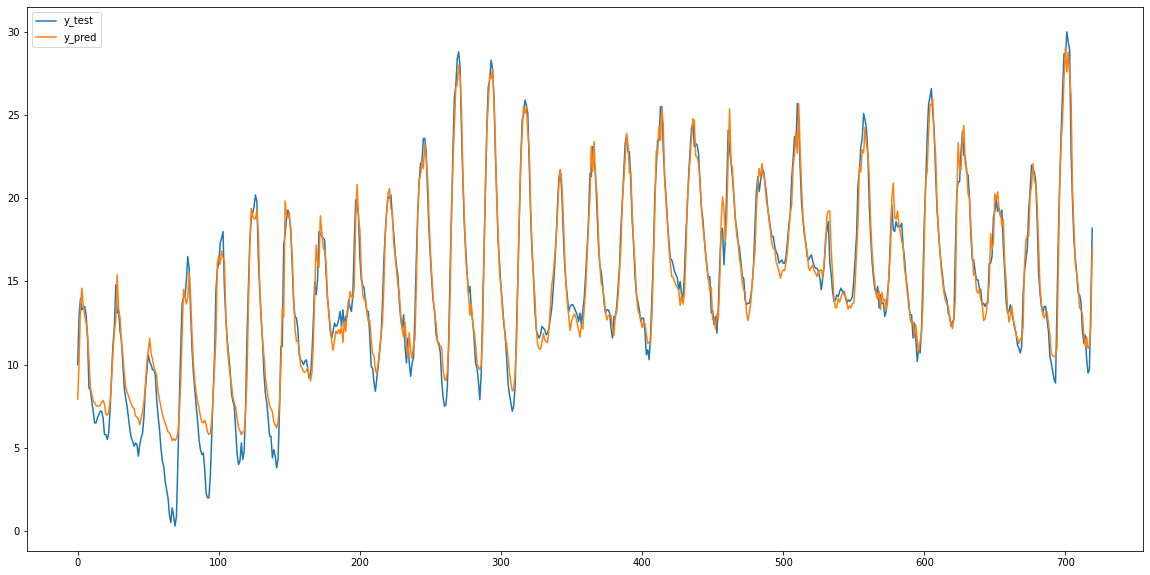

In [12]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(y_test.squeeze()[:,0][-24*30:], label="y_test")
ax.plot(y_pred[:,0][-24*30:], label="y_pred")
ax.legend()
plt.show()